## PHYS 362 Set 4/5 continued
## 3. Problem statement:
The two-dimensional Ising model with nearest and next-nearest-neighbor interactions has N = L × L spins which can take the values Si = ±1 at every site of a square lattice i = 1, 2, . . . N. Around each spin, there are 8 possible interactions. These eight interactions with each spin make a little square. The four longer-ranged next-nearest- neighbor interactions make the model somewhat more isotropic than the Ising model. The spins on the edges of the square lattice interact via periodic-boundary conditions so that, for example, the interaction directly to the East of SL involves S1 — and so on, for the other directions.

Consider J = J_{next_nn} and H = 0. Simulate the system via the Monte Carlo method. Estimate magnetization(T), the energy per spin e(T ), heat_capacitance(T), and Tc. Estimate the exponents β and α. Are your exponents consistent with those for the two-dimensional Ising model? How important are finite-size effects (the fact that L is not infinite)? Explain your reasoning.

In [1]:
from numpy import *
import matplotlib.pyplot as plt
from random import *
import scipy
import scipy.optimize
from scipy.optimize import curve_fit as opt

## Useful functions ##

In [2]:
#to calculate total energy in the system (when H = 0)
def get_Energy(spins, L):
    E =0.
    for i in range(len(spins)):
        for j in range (len(spins)):
            S = spins[i,j]
            neighb = spins[(i+1)%L, j] +spins[(i-1)%L, j] + spins[i, (j+1)%L] + spins[i, (j-1)%L] #energy from nearest neighbours
            next_neighb = (spins[(i+1)%L, (j+1)%L] + spins[(i+1)%L, (j-1)%L] + spins[(i-1)%L, (j+1)%L] + spins[(i-1)%L, (j-1)%L]) #energy from next nearest neighbours
            E += - (neighb+next_neighb) * S #formula for energy
    return E/2 #no double counting

In [3]:
# initializing the lattice totally randomly
def initialize(L, rand):
    spins = zeros((L, L), dtype=int)
    if rand==True:

        for i in range(L):
            for j in range(L):
                spins[i,j] = choice([-1, 1])
    if rand == False:

        for i in range(L):
            for j in range(L):
                spins[i,j] = 1           
    return spins


In [4]:
def deltaE(spins, i, j, L):
    S = spins[i,j]
    tot_neighb = spins[(i+1)%L, j] +spins[(i-1)%L, j] + spins[i, (j+1)%L] + spins[i, (j-1)%L] + (spins[(i+1)%L, (j+1)%L] + spins[(i+1)%L, (j-1)%L] + spins[(i-1)%L, (j+1)%L] + spins[(i-1)%L, (j-1)%L])
    delta_E = 2*S*tot_neighb
    return delta_E

In [5]:
#monte carlo step
def McMove(spins, L, T):
    E = get_Energy(spins, L)
    N = L*L
    for k in range(N):
        itest = int(random()*L)
        jtest = int(random()*L)
        (i, j) = (itest, jtest)
        S = spins[i, j]
        delta_E = deltaE(spins, i, j, L)
        
        # use difference in energy between states to compute boltzmann probability of spin flipping
        prob = exp(-(delta_E/T))
        if prob > random():
            spins[i,j] = -S
            E += delta_E #adjust energy to reflect a flip
    return spins
        
        

In [6]:
#make a function that will record the state as it evolves in time

def ising_recording(mcs, L, T):
    spins = initialize(L, rand=True)
    
    all_spins = zeros((L, L, mcs), dtype = int)
    for k in range(mcs):
        all_spins[:, :, k] = spins #record the current state in array all_states
        spins = McMove(spins, L, T) #run the model
        
    return all_spins


In [7]:
#if we don't want to record all the steps and only want final state
def ising_final(mcs, L, T):
    spins = initialize(L, rand=False)
    for k in range(mcs):
        spins = McMove(spins, L, T) #run the model
        
    return spins # only taking the final spins

## Finding a sufficient grid size ##

To determine how big of a grid-size we need to characterize the 2D Ising model, a huge hint is correlation length. In class, we saw that a spin could affect a spin a distance $r$ away following like this:

$ <S_{i} S_{i+r}>\space = \space e^{\space \frac{-r}{\zeta}}$,

where $\zeta$ is the correlation length:

$\zeta = - \dfrac{1}{\text{ln}(\tanh(\frac{J+ J_{nnn}}{k_{B}T}))}$

Just looking at the exponential, we can see that the correlations in space between spins (<...>) will drop below 1% at a distance $ r= 5\zeta$. So, to be extra safe, we can say we need a grid size larger than 7$\zeta$. Now we don't explicitly know $\zeta$ since we don't know $J+J_{nnn}$. However, we can estimate $\zeta$ to be approximately of order 1, and therefore of maximum order 10.

So, L > 7 * 10 should be sufficient. To be safe, we take L = 80.

## Finding a sufficient amount of MC steps ##

We will run the model using 400 Monte Carlo steps (just a guess) at T = 1 J/kb. We will know that this is a sufficient amount of steps if the system can completely magnetize (starting from a randomized state) in that time.

In [8]:
#parameters of the run
mcs = 400 #number of steps
L = 80 #lattice is L*L
T = 1. #temperature in units J/Kb

In [9]:
#run the model setting rand=True in ising_recording (so we start with random state)
all_spins = ising_recording(mcs, L, T)

In [10]:
#plot results at 7 times

times = 7
timechecks = geomspace(1, mcs, num = times)
timechecks = timechecks.astype(int)

#initial check at 0
timechecks[0]=0
timechecks[-1] = timechecks[-1] -1

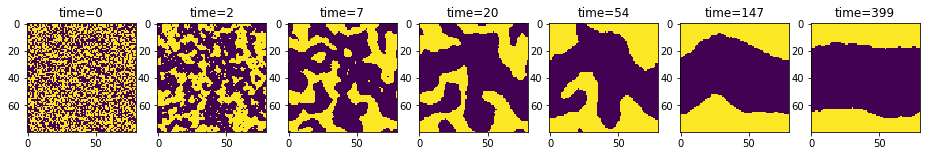

In [11]:
# plot the system at different steps.
fig, axes = plt.subplots(ncols = times, figsize=(16,16))
for i,axe in enumerate(axes) :
    now =timechecks[i]
    axe.set_title("time={}".format(now))
    axe.imshow(all_spins[:,:,now])


Clearly the system is fully magnetized at 400 steps! So, this is a good number of Monte Carlo  steps to take when characterizing the system.

Now we must measure Tc, m, e, and c_v.

## Finding Tc ##

Tc is approximately $2*Tc_{\text{neighbours}}$, since J = Jnnn and:

        number of neighbours = number of next nearest neighbours.

In [12]:
theory_tc = 2*2.7
#array of temperature in units of J/kb
temps = linspace(0.5, 10, num=100)

In [13]:
#loop over temperature array
L_tc = 60 #enough to smooth over boundary being weird
mcs = 400 #enough to counter-act initial bias of having perfectly random state

In [14]:
#this 3d-array will contain the final config for given temperature
#set rand=False in ising_final so we start with a magnetized state

t_spin = zeros((L_tc, L_tc, len(temps)), dtype = int)
for k,temp in enumerate(temps):
    t_spin[:,:,k] = ising_final(mcs, L_tc, temp)

In [15]:
#plot lattice at different temperatures to deduce critical temperature
#we will see where the state becomes random.
times_2=10
timechecks2 = linspace(0, len(temps), num=times_2)
timechecks2 = timechecks2.astype(int)
timechecks2[-1] = timechecks2[-1] -1

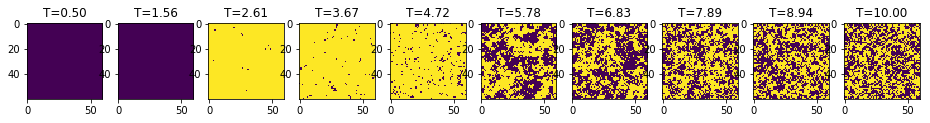

In [16]:
fig, axes = plt.subplots(ncols = times_2, figsize=(16,16))
for i,axe in enumerate(axes):
    now=timechecks2[i]
    temp_now=temps[now]
    axe.set_title("T={:3.2f}".format(temp_now))
    axe.imshow(t_spin[:,:,now])

Looking at where the magnetization shifts drastically, we can deduce that the critical temperature occurs between 4.72 and 5.78

Let's look into the range 5.5 to 6 with more iterations.

In [17]:
times3=5
low_index = abs(temps-5).argmin()
max_index = abs(temps-5.5).argmin()
timechecks3=linspace(low_index, max_index, num=times3)
timechecks3=timechecks3.astype(int)

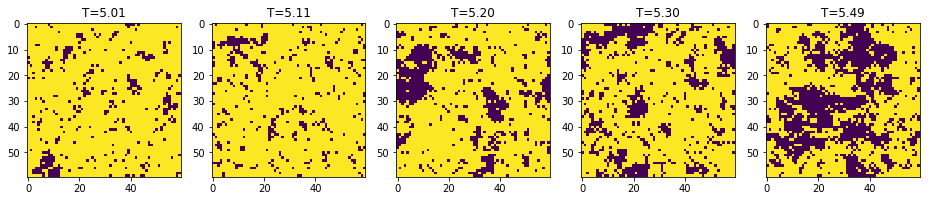

In [18]:
fig, axes = plt.subplots(ncols=times3, figsize=(16,16))
for i,axe in enumerate(axes):
    now=timechecks3[i]
    tempnow=temps[now]
    axe.set_title("T={:3.2f}".format(tempnow))
    axe.imshow(t_spin[:,:,now])

It appears magnetized clusters stop forming at around T = 5.30 in units of J/(kB).

**So, we say the critical temperature occurs around 5.30 J/kb.**

## More  useful  functions ##

To compute other paramters (m and Cv), need our lattice of spins on a time axis (corresponding to number of monte carlo steps), as well as on a temperature axis.

Starting by modifying our original McMove and ising_recording functions so they also output energy.

In [19]:
#modify McMove so it returns energy of microstate
#use pre-calculated exponentials "cases", to avoid calculating exponential for probability every time
def McMove_withE(spins, L, T, cases):
    E = get_Energy(spins, L)
    N = L*L
    for k in range(N):
        itest = int(random()*L)
        jtest = int(random()*L)
        (i, j) = (itest, jtest)
        S = spins[i, j]
        delta_E = deltaE(spins, i, j, L)
        
        # use difference in energy between states to compute boltzmann probability of spin flipping
        #if differnce is negative, flip.
        if delta_E <= 0:
            spins[i,j] = -S
            E += delta_E #flip modifies energy
        
        #if difference is positve, get probability (using cases) and compare to random number
        else:
            index = int((16-delta_E)/4)
            prob = cases[index] #prob is boltzmann probability exp(-deltaE/T)
            if prob > random():
                spins[i,j] = -S
                E += delta_E #adjust energy to reflect a flip
    return spins, E #get back lattice and energy

In [20]:
#modify ising_recording so it returns energy as well
# use cases again to avoid computing exponential every time

def E_ising_recording(mcs, L, T):
    spins = initialize(L, False)
    E_array = zeros((mcs), dtype=float)
    
    #cases of possible exponentials
    possible_deltaE = asarray([16,12,8,4])
    cases = exp(-(possible_deltaE)/T)
    
    all_spins = zeros((L, L, mcs), dtype = int) #run the model
    for k in range(mcs):
        all_spins[:, :, k] = spins #record the current state in array all_states
        spins, E_array[k] = McMove_withE(spins, L, T, cases) #take a step and record energy
        
    return all_spins, E_array

## Running and recording the model for all temperatures  

To plot magnetization, heat capacity and energy as a function of temperature, we need to record the evolution of the grid through an array of temperatures, over many Monte Carlo steps. Beware: this takes about 30 minutes to run.

In [21]:
m_lattice = 80 #Lattice size we determined was good
m_mcs = 500 #We determined 400 to be sufficient amount of MC steps, so 500 is a very safe choice

#4d array to have MC steps for all temperatures

tot_spins = zeros((m_lattice, m_lattice, m_mcs, len(temps)), dtype=int)
ene = zeros((m_mcs, len(temps)), dtype=float)

#fill the array. this takes a while.
for k, temp in enumerate(temps):
    tot_spins[:,:,:,k], ene[:,k] = E_ising_recording(m_mcs, m_lattice, temp)

### Finding m(T) and fitting for $\beta$ ###

To get magnetization as a function of temperature, we need to average over all the monte carlo steps at each temperature.

In [22]:
#get m by taking average over full grid
m_avg_array = average(tot_spins, axis=(0,1))

In [23]:
#we want magnetization as a function of temperature
m_temp = zeros(temps.shape, dtype=object)

#average over each temperature and fill aray m_temp
for i in range(len(temps)):
    m_temp[i] = average(m_avg_array[:,i], axis=0)

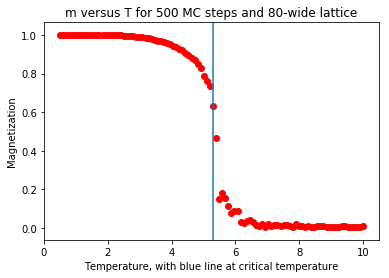

In [24]:
# plot magnetization
Tc=5.30
fig = plt.figure()
plt.title("m versus T for {0} MC steps and {1}-wide lattice".format(m_mcs, m_lattice))
plt.scatter(temps, m_temp, c='red')
plt.axvline(x=Tc)
plt.xlabel('Temperature, with blue line at critical temperature')
plt.ylabel('Magnetization')
plt.show()

Next step is to fit this to our function for m(T) and determine the value of the exponent, $\beta$:

$m(T) = (T_{c}-T)^{\beta}$

Recall mean-field theory yielded $\beta = 0$. What is $\beta$ here? To estimate it, use scipy.curve_fit

In [25]:
#function we want to fit m to all the way up to Tc (straight line after that)
def tc_fit(tem, Tc, beta, c, d):
    return ((absolute(Tc-tem))**(beta-1)) * (Tc-tem) + c*tem + d

In [26]:
#this function fits the magnetization data, plots the best fit, and returns the best beta
def find_beta(m_temp, Tc, low_temp, high_temp, numt):
    temps = linspace(low_temp, high_temp, num=numt)
    
    #we are only interested in fitting the portion of the curve T<Tc (straight line after)
    temps_cut = array(temps[:50], dtype='float64')
    m_temp_cut = array(m_temp[:50], dtype='float64')
    #fit
    m_best, m_cov = opt(tc_fit, temps_cut, m_temp_cut, p0 = [Tc,0.1,0,0])
    #get best value
    (tc_best, beta_best, c_best, d_best) = m_best
    
    #get errors
    err = sqrt(diag(m_cov))
    tc_best_err = err[0]
    beta_best_err = err[1]
    
    #print results
    print("Fit Tc = {:.3} +/- {:.1}".format(tc_best, tc_best_err))
    print("Fit alpha = {:.3} +/- {:.1}".format(beta_best, beta_best_err))
    
    best_fit = tc_fit(temps_cut, tc_best, beta_best, c_best, d_best)#define tc_fit_abs later
    
    fig = plt.figure()
    plt.title("Magnetization fit with beta = {:.3} +/- {:.1}".format(beta_best, beta_best_err))
    plt.scatter(temps_cut, m_temp_cut)
    plt.plot(temps_cut, best_fit, color='orange', label="Best fit")
    plt.xlabel("Temperature in units J/kb")
    plt.ylabel("Magnetization")
    plt.legend()
    plt.show()
    
    return beta_best, beta_best_err, m_best
    

Fit Tc = 5.42 +/- 0.02
Fit alpha = 0.171 +/- 0.007


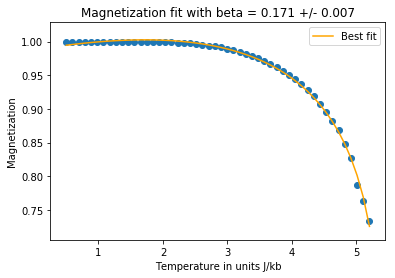

In [27]:
beta, beta_err, best_m = array(find_beta(m_temp, Tc, 0.5, 10.0, 100), dtype=object)

The exponent found here is **consistent** with the $\beta$ resulting from the analytical 2D Ising model, $\frac{1}{8} = 0.125$.

## Finding e(T) ##

In [28]:
#get function to define energy per spin
#want it to return 1d array of energy per spin for each temperature

def E_per_spin(energy, temp):
    #calculate E and then average over MC steps
    E_T = zeros(temp.shape, dtype=float)
    for i in range(len(temp)):
        E_T[i] = average(energy[:,i], axis=0)
    
    N = m_lattice**2 #number of spins
    e_T = E_T / N #divid energy to get energy per spin
    
    return e_T
    

In [29]:
#get the energy per spin with E_per_spin
e_T = E_per_spin(ene, temps)

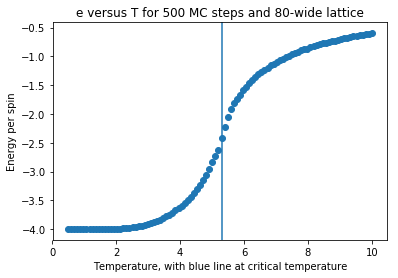

In [30]:
#plot e versus T
fig = plt.figure()
plt.title("e versus T for {0} MC steps and {1}-wide lattice".format(m_mcs, m_lattice, m_lattice))
plt.scatter(temps, e_T)
plt.axvline(x=Tc)
plt.xlabel('Temperature, with blue line at critical temperature')
plt.ylabel('Energy per spin')
plt.show()

## Finding $C_{v}$ and fitting for $\alpha$  ##

We know that the heat capacity is the derivative of energy with respect to T. So we take the tangent of the e(T) curve. We can do this discretely using one of numpy's magical (except it's not magic) tools, np.gradient.

In [31]:
delta_T = abs(temps[1]-temps[0])
C_v = gradient(e_T, delta_T)

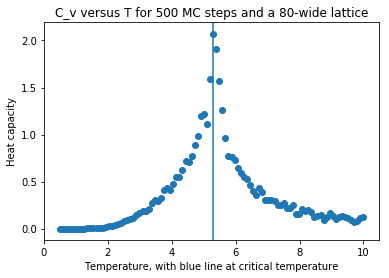

In [32]:
#plot cv versus temperature
fig = plt.figure()
plt.title("C_v versus T for {0} MC steps and a {1}-wide lattice".format(m_mcs, m_lattice, m_lattice))
plt.scatter(temps, C_v)
plt.axvline(x=Tc)
plt.xlabel('Temperature, with blue line at critical temperature')
plt.ylabel('Heat capacity')
plt.show()

Now we want to estimate $\alpha$. Recall what we had analytically:

$C_{v} = |T - T_{c}|^{-\alpha}$ where we found $\alpha = 0$

What is $\alpha$ here? To estimate it, use scipy.curve_fit

In [33]:
#function we want to fit Cv to
def tc_fit_abs(temps, Tc, alpha, c, d):
    return absolute(Tc-temps)**(-alpha)+c*temps+d

In [34]:
#this function fits the magnetization data, plots the best fit, and returns the best beta

def find_alpha(Cv, Tc, low_temp, high_temp, numt):
    temps = linspace(low_temp, high_temp, num=numt)
    
    #fit
    cv_best, cv_cov = opt(tc_fit_abs, xdata = temps, ydata = Cv, p0 = [Tc,0.1,0, 0])
    
    #get best value
    (tc_best, alpha_best, c_best, d_best) = cv_best
    
    #get errors
    err = sqrt(diag(cv_cov))
    tc_best_err = err[0]
    alpha_best_err = err[1]
    
    #print results
    print("Fit Tc = {:.3} +/- {:.1}".format(tc_best, tc_best_err))
    print("Fit alpha = {:.3} +/- {:.1}".format(alpha_best, alpha_best_err))
    
    best_fit = tc_fit_abs(temps, tc_best, alpha_best, c_best, d_best)#define tc_fit_abs later
    
    fig = plt.figure()
    plt.title("Heat capacity fit with alpha = {:.3} +/- {:.1}".format(alpha_best, alpha_best_err))
    plt.scatter(temps, Cv)
    plt.plot(temps, best_fit, label="Best fit", color='orange')
    plt.xlabel("Temperature in units J/kb")
    plt.ylabel("Heat Capacity")
    plt.legend()
    plt.show()
    
    return alpha_best, alpha_best_err, cv_best
    

Fit Tc = 5.34 +/- 0.003
Fit alpha = 0.34 +/- 0.007


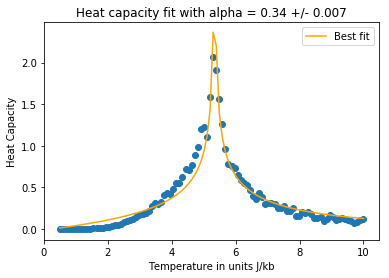

In [35]:
alpha, alpha_err, best_cv = find_alpha(C_v, Tc, 0.5, 10.0, 100)

The theoretical model tells us there should be a discontinuity at critical temperature (which means $\alpha_{\text{theoretical}} = 0$). Clearly, the computer cannnot return a discontinuity in the fit. While 0.309 +/- 0.01 seems rather father from 0, it is actually not a bad estimate. A tiny change in the cusp causes a rapidly  increasing exponent, as we can see by plotting on MatLab or Desmos. So while the exponents are not consistent on paper, the discrepancy is not worrisome. 

## Importance of finite size-effects

Let's consider the order of the correction distinguishing the critical temperatures of an infinite system from a finite system (size $L$). In class, we saw that if the $L=\zeta$, we have:

$T_{c}(\infty) \space = \space T_{c}(L) \space + \space O(\dfrac{1}{L^{\nu}})$

What is the correction here?

$O(\dfrac{1}{L^{\nu}}) \space = \space O(\dfrac{1}{80^{\nu}}) \space = \space O(10^{-1})$

This would be the correction if the correlation length was approximately 80 as well. In reality we know it to be about an order of mangitude smaller. So we expect the system to magnetize less quickly and have a higher slightly higher $T_{c}$. Nevertheless, this equation provides us with some insight on the importance of finite size effects: we expect our finite $T_{c}$ to be slightly smaller than the true $T_{c}$. Again, this makes conceptual sense since the boundary conditions of the finite system can allow for a spin to influence itself, meaning the entire system magnetizes more easily.

## 4. Problem statement:

 - Compare critical temperature obtained using Monte Carlo versus critical temperature obtained via mean field theory.

$T_{c_{\text{monte carlo}}} = 5.3 +/- 0.1 \space \text{J/kb}$

(Notice that this is the Tc determined by visually evaluating at which temperature the grid demagnetizes. We had also obtained 2 other versions of critical temperature when fitting for $\alpha$ and $\beta$ but we will not consider those.)

$T_{c_{\text{mean theory}}} = 2* T_{c_{\text{next neighbours}}} = 2*q\space \text{J/kb} = 8 \space \text{J/kb}$

Clearly, the two results are not consistent. Why does mean field theory yield a higher critical temperature? It turns out that this theory is not ideal for the 2D Ising model since it is most suitable for systems with small fluctuations. Here, fluctuations ar eproportional to grid-size (as seen in class). We can further understand the discrepancy just by looking at how mean field theory works. It assumes that the entire system has the same average spin as the nearest and next-nearest neighbours. Clearly, such an assumption imposes more "order" on the  system and requires more "energy" (a higher temperature) for it to become disordered than the Monte Carlo method which does not not assume this to be true.

- Compare dependence on temperature of $m$ and $C_{v}$

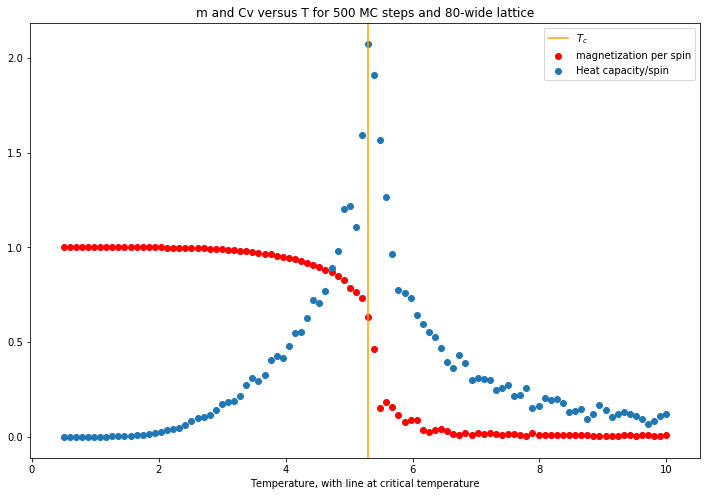

In [36]:
##### using the generated data sets from earlier

Tc=5.30
fig = plt.figure(figsize=(12,8))
plt.title("m and Cv versus T for 500 MC steps and {1}-wide lattice".format(m_mcs, m_lattice))

#plot magnetization
plt.scatter(temps, m_temp, c='red', label = 'magnetization per spin')
#plot heat capacity
plt.scatter(temps, C_v, label='Heat capacity/spin')

plt.axvline(x=Tc, color='orange', label ='$T_{c}$')
plt.xlabel('Temperature, with line at critical temperature')
plt.legend()
plt.show()

We see that magnetization drops off right where heat capacity peaks. Why is that? Magnetization is proportional to average energy--a highly magnetized system has little energy. When the system magnetization drops at the critical temperature, it becomes more disordered, and  thus has more energy. On the other hand, heat capactiy measures how much  energy  changes with respect to temperature. So when the system experiences a radical change in energy as it hits critical temperature, we expect heat capacity to peak (with  respect to temperature): there is a large change enery for small change in temperature. As such, the temperature-dependences of $m$ and $C_{v}$ are connected via energy.